In [1]:
!pip install py7zr

In [2]:
import torch
from torch import nn
import torchvision
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import datasets,transforms
from torchvision.transforms import ToTensor,InterpolationMode
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import random
import requests
import pandas as pd
from pathlib import Path
import numpy as np
import os
import py7zr
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, recall_score
from tqdm.auto import tqdm
from collections import Counter

In [3]:
# set device by checking if gpu is available
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [4]:
SEED = 50

torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

In [5]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')

# root directory for data
root_dir = 'drive/MyDrive/Colab Notebooks/Deep Learning Fundamentals/Assignment 2/cifar-10/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**DATA PREPROCESSING AND VISUALIZATION**

In [6]:
with py7zr.SevenZipFile(root_dir + 'train.7z', mode='r') as archive:
    archive.extractall(path='./')

# with py7zr.SevenZipFile(root_dir + 'test.7z', mode='r') as archive:
#     archive.extractall(path='./')

In [7]:
df = pd.read_csv(root_dir + 'trainLabels.csv')
df.head()

,id,label
0,1,frog
1,2,truck
2,3,truck
3,4,deer
4,5,automobile


In [8]:
labels = dict()

for _,row in df.iterrows():
    labels[row['id']] = row['label']

<ipython-input-9-73aca64a5246>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Labels', data=label_df, palette='pastel', edgecolor='black')


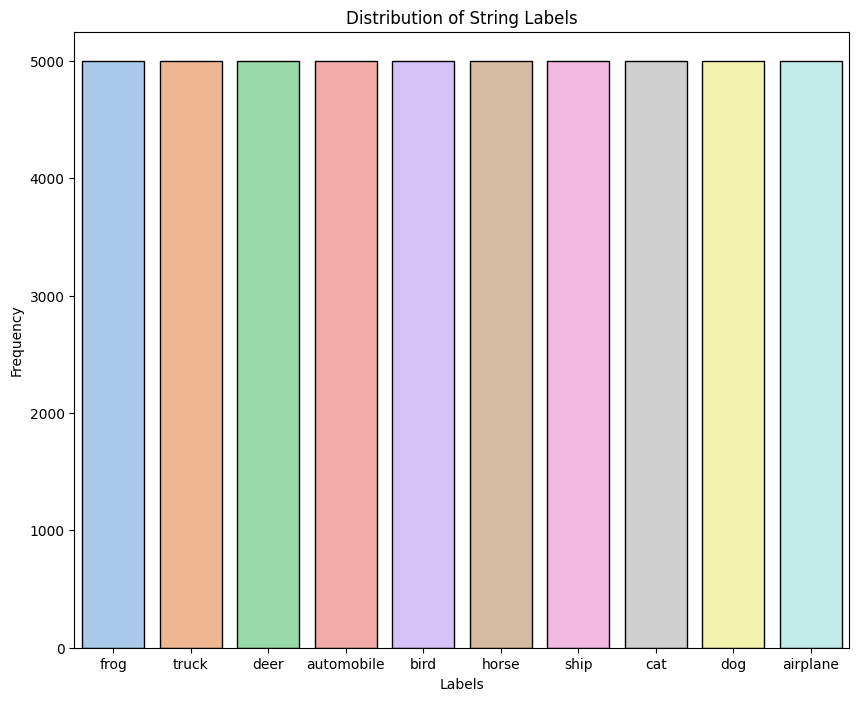

In [9]:
# Example NumPy array of string labels
labels_list = df['label'].values

# Convert the labels to a pandas DataFrame
label_df = pd.DataFrame({'Labels': labels_list})

plt.figure(figsize=(10, 8))

# Create a count plot using seaborn
sns.countplot(x='Labels', data=label_df, palette='pastel', edgecolor='black')

# Add labels and title
plt.xlabel('Labels')
plt.ylabel('Frequency')
plt.title('Distribution of String Labels')

# Show the plot
plt.show()

In [10]:
class CIFAR10(Dataset):
    def __init__(self, image_folder, labels, transform=None):
        self.image_folder = image_folder
        self.transform = transform
        self.image_filenames = os.listdir(image_folder)  # List all image files in the folder
        self.labels = labels
        self.classes = sorted(list(set(labels.values())))

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):

        # Load image
        img_name = os.path.join(self.image_folder, self.image_filenames[idx])
        image = Image.open(img_name).convert("RGB")  # Convert image to RGB mode

        # Apply transformations (if any)
        if self.transform:
            image = self.transform(image)

        img_id = int(self.image_filenames[idx].split('.')[0])
        img_class = self.labels[img_id]
        label = self.classes.index(img_class)

        return image, label

In [11]:
image_transform = transforms.Compose([
    transforms.Resize(size=(224,224)), # resize the image
    transforms.TrivialAugmentWide(num_magnitude_bins=31), # apply data augmentation
    transforms.ToTensor(), # convert the image into a tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [12]:
cifar_data = CIFAR10('train/', labels, image_transform)

In [13]:
class_names = cifar_data.classes
print(class_names)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [14]:
print(len(cifar_data))

50000


In [15]:
image,label = cifar_data[0]
print(image.shape)
print(label)

torch.Size([3, 224, 224])
9


Text(0.5, 1.0, 'truck')

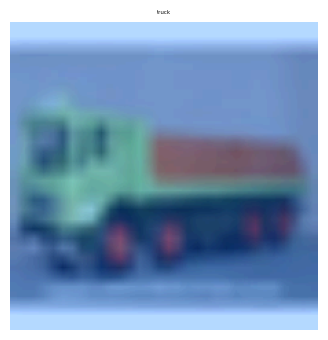

In [16]:
# rearrange the image dimensions
image_permute = image.permute(1,2,0)

# display the image
plt.figure(figsize=(6,4))
plt.imshow(image_permute)
plt.axis("off")
plt.title(cifar_data.classes[label], fontsize=4)

In [17]:
# sizes for training and testing sets
train_size = int(0.8 * len(cifar_data))
test_size = len(cifar_data) - train_size

# split the dataset into training and testing sets
train_data, test_data = random_split(cifar_data, [train_size, test_size])

In [18]:
BATCH_SIZE = 32

# convert dataset to dataloader
train_dataloader = DataLoader(train_data,
                              batch_size=BATCH_SIZE,
                              num_workers=os.cpu_count(),
                              shuffle=True)

test_dataloader = DataLoader(test_data,
                             batch_size=BATCH_SIZE,
                             num_workers=os.cpu_count(),
                             shuffle=False)

In [19]:
# get a batch of images and labels from the dataloader
train_images,train_labels = next(iter(train_dataloader))
print(train_images.shape)
print(train_labels.shape)

torch.Size([32, 3, 224, 224])
torch.Size([32])


**TRAINING**

In [20]:
# function to calculate accuracy
def accuracy(labels,preds):
    correct = torch.eq(labels,preds).sum().item()
    acc = (correct/len(labels))*100
    return acc

In [21]:
def train(model, dataloader, criterion, optimizer):
    # set the model to training mode
    model.train()

    train_loss, train_acc = 0, 0

    for batch, (images, labels) in enumerate(dataloader):
        # send data to target device
        images, labels = images.to(device), labels.to(device)

        # pass the data to the model and get model outputs
        logits = model(images)

        # calulate the loss
        loss = criterion(logits, labels)
        train_loss += loss.item()

        # clear the gradients
        optimizer.zero_grad()

        # calculate the gradients
        loss.backward()

        # update the model parameters
        optimizer.step()

        # calculate the accuracy
        train_acc = train_acc+accuracy(labels,torch.argmax(logits,dim=1))

    # calculate the mean loss
    train_loss = train_loss / len(dataloader)

    # calculate the mean accuracy
    train_acc = train_acc / len(dataloader)

    return train_loss,train_acc

In [22]:
def test(model, dataloader, criterion):
    # set the model to testing mode
    model.eval()

    test_loss, test_acc = 0, 0

    with torch.inference_mode():
        for batch, (images, labels) in enumerate(dataloader):
            # send data to target device
            images, labels = images.to(device), labels.to(device)

            # pass the data to the model and get model outputs
            logits = model(images)

            # calulate the loss
            loss = criterion(logits, labels)
            test_loss += loss.item()

            # calculate the accuracy
            test_acc = test_acc+accuracy(labels,torch.argmax(logits,dim=1))

    # calculate the mean loss
    test_loss = test_loss / len(dataloader)

    # calculate the mean accuracy
    test_acc = test_acc / len(dataloader)

    return test_loss,test_acc

In [23]:
def evaluate(model, dataloader, class_names):
    # Set the model to evaluation mode
    model.eval()

    all_preds = []
    all_labels = []
    all_top5_preds = []

    with torch.inference_mode():
        for batch, (images, labels) in enumerate(dataloader):
            # Send data to target device
            images, labels = images.to(device), labels.to(device)

            # Get predictions from the model
            logits = model(images)
            preds = torch.argmax(logits, dim=1)
            top5_preds = torch.topk(logits, k=5, dim=1).indices  # Get top 5 predictions

            # Accumulate predictions and true labels
            all_preds = all_preds + preds.cpu().tolist()
            all_labels = all_labels + labels.cpu().tolist()
            all_top5_preds = all_top5_preds + top5_preds.cpu().tolist()

    # Convert to numpy arrays
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    all_top5_preds = np.array(all_top5_preds)

    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds)

    # Calculate overall accuracy
    overall_accuracy = accuracy_score(all_labels, all_preds)

    # Calculate top-5 accuracy
    top5_correct = 0
    for i in range(len(all_labels)):
        if all_labels[i] in all_top5_preds[i]:
            top5_correct += 1
    top5_accuracy = top5_correct / len(all_labels)

    # Calculate per-class accuracy
    per_class_accuracy = cm.diagonal() / cm.sum(axis=1)

    # Calculate per-class recall
    per_class_recall = recall_score(all_labels, all_preds, average=None)

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

    # Print metrics
    print(f"Overall Accuracy: {overall_accuracy:.4f}")
    print(f"Top-5 Accuracy: {top5_accuracy:.4f}")
    print("\nPer-Class Accuracy:")
    for i, class_name in enumerate(class_names):
        print(f"{class_name}: {per_class_accuracy[i]:.4f}")

    print("\nPer-Class Recall:")
    for i, class_name in enumerate(class_names):
        print(f"{class_name}: {per_class_recall[i]:.4f}")

In [24]:
# function to plot the loss and accuracy
def plot_curves(results):
    plt.figure(figsize=(15,7))
    epochs = range(1,len(results["train_loss"])+1)

    # plot the losses
    plt.subplot(1,2,1)
    plt.plot(epochs,results["train_loss"], label="Training Loss")
    plt.plot(epochs,results["test_loss"], label="Test Loss")
    plt.title("LOSS")
    plt.xlabel("Epochs")
    plt.legend()

    # # plot the accuracies
    # plt.subplot(1,2,2)
    # plt.plot(epochs,results["train_acc"], label="Training Accuracy")
    # plt.plot(epochs,results["test_acc"], label="Test Accuracy")
    # plt.title("ACCURACY")
    # plt.xlabel("Epochs")
    # plt.legend()

**VGG-16**

In [25]:
# get pretrained model weights
weights = torchvision.models.VGG16_Weights.DEFAULT

model = torchvision.models.vgg16(weights=weights).to(device)
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [26]:
# freeze the convolutional layers of the model
for param in model.features.parameters():
    param.requires_grad = False

In [27]:
# update the classifier of the model
# the output size of the layer should be same as the number of classes in the data
model.classifier = nn.Sequential(
    nn.Linear(25088,4096),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.5,inplace=False),
    nn.Linear(4096,4096),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.5,inplace=False),
    nn.Linear(4096,len(cifar_data.classes))
).to(device)

print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [28]:
# loss function
criterion = nn.CrossEntropyLoss()

# optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [29]:
epochs = 4

# results dictionary
results = {"train_loss": [],
            "test_loss": [],
}

In [30]:
for epoch in tqdm(range(epochs)):
    train_loss,train_acc = train(model,train_dataloader,criterion,optimizer)
    test_loss,test_acc = test(model,test_dataloader,criterion)

    print(f"Epoch: {epoch+1} | train_loss: {train_loss:.4f} | train_acc: {train_acc:.2f}% | test_loss: {test_loss:.4f} | test_acc: {test_acc:.2f}%")
    #print(f"Epoch: {epoch+1} | train_loss: {train_loss:.4f} | train_acc: {train_acc:.2f}%")

    # update the results dictionary
    results["train_loss"].append(train_loss)
    #results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    #results["test_acc"].append(test_acc)

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.3325 | train_acc: 58.10% | test_loss: 0.9648 | test_acc: 68.76%
Epoch: 2 | train_loss: 1.2050 | train_acc: 62.31% | test_loss: 0.9695 | test_acc: 69.18%
Epoch: 3 | train_loss: 1.1481 | train_acc: 64.04% | test_loss: 1.0052 | test_acc: 68.59%
Epoch: 4 | train_loss: 1.0900 | train_acc: 65.08% | test_loss: 0.9428 | test_acc: 69.40%


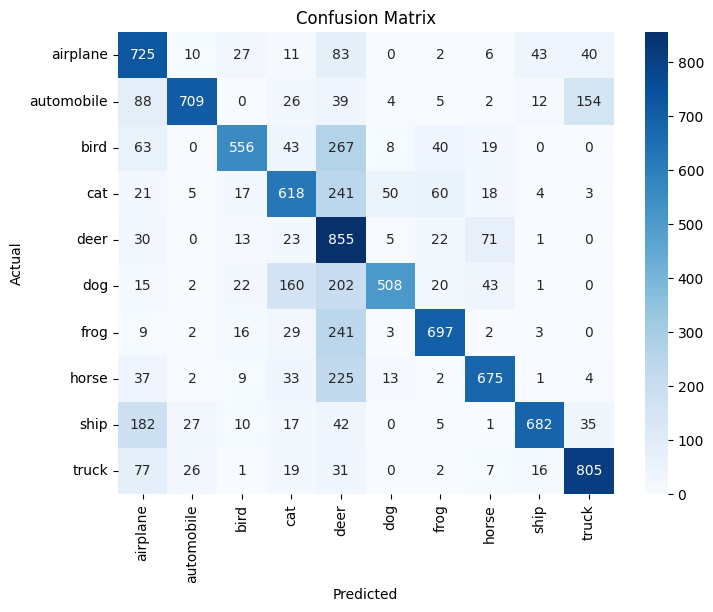

Overall Accuracy: 0.6830
Top-5 Accuracy: 0.9472

Per-Class Accuracy:
airplane: 0.7656
automobile: 0.6824
bird: 0.5582
cat: 0.5959
deer: 0.8382
dog: 0.5221
frog: 0.6956
horse: 0.6743
ship: 0.6813
truck: 0.8181

Per-Class Recall:
airplane: 0.7656
automobile: 0.6824
bird: 0.5582
cat: 0.5959
deer: 0.8382
dog: 0.5221
frog: 0.6956
horse: 0.6743
ship: 0.6813
truck: 0.8181


In [31]:
evaluate(model, test_dataloader, class_names)

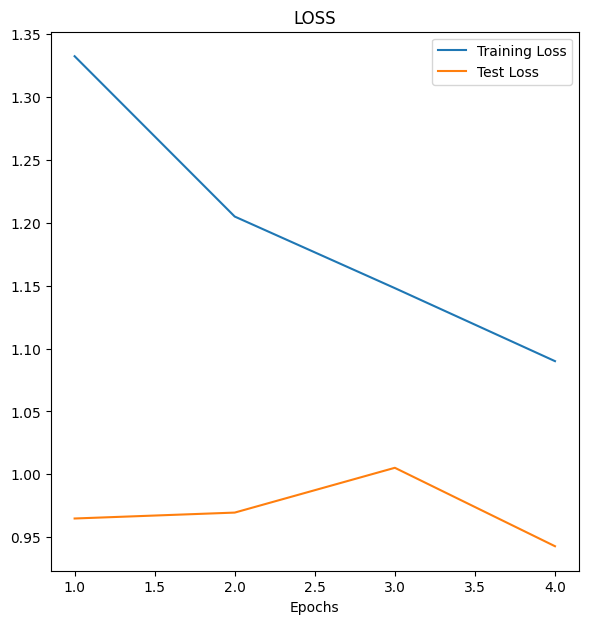

In [32]:
plot_curves(results)

**RESNET-18**

In [ ]:
# get pretrained model weights
weights = torchvision.models.ResNet18_Weights.DEFAULT

model = torchvision.models.resnet18(weights=weights).to(device)
print(model)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 114MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
# freeze the convolutional layers of the model
for param in model.parameters():
    param.requires_grad = False

In [ ]:
# update the classifier of the model
# the output size of the layer should be same as the number of classes in the data
model.fc = nn.Linear(512,len(cifar_data.classes)).to(device)

print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
# loss function
criterion = nn.CrossEntropyLoss()

# optimizer
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)

In [ ]:
epochs = 4

# results dictionary
results = {"train_loss": [],
            "test_loss": [],
}

In [ ]:
for epoch in tqdm(range(epochs)):
    train_loss,train_acc = train(model,train_dataloader,criterion,optimizer)
    test_loss,test_acc = test(model,test_dataloader,criterion)

    print(f"Epoch: {epoch+1} | train_loss: {train_loss:.4f} | train_acc: {train_acc:.2f}% | test_loss: {test_loss:.4f} | test_acc: {test_acc:.2f}%")
    #print(f"Epoch: {epoch+1} | train_loss: {train_loss:.4f} | train_acc: {train_acc:.2f}%")

    # update the results dictionary
    results["train_loss"].append(train_loss)
    #results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    #results["test_acc"].append(test_acc)

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1268 | train_acc: 62.49%
Epoch: 2 | train_loss: 0.9371 | train_acc: 67.75%
Epoch: 3 | train_loss: 0.9046 | train_acc: 68.94%
Epoch: 4 | train_loss: 0.8883 | train_acc: 69.16%


In [ ]:
evaluate(model, test_dataloader, class_names)

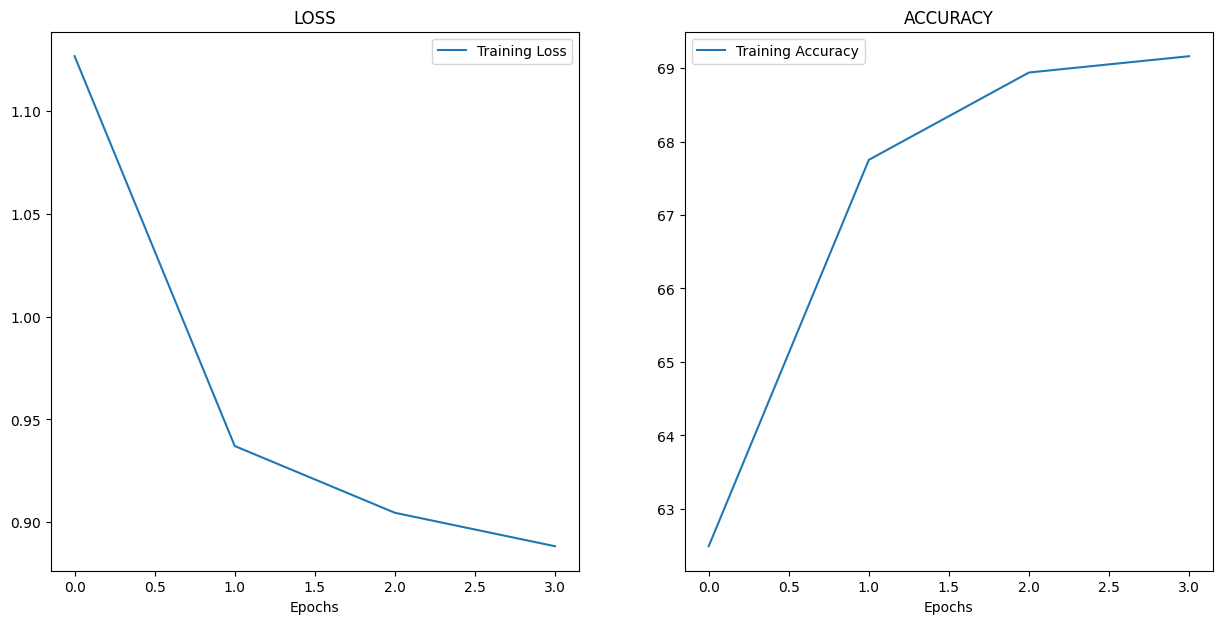

In [ ]:
plot_curves(results)

**DENSENET MODEL**

In [25]:
# get pretrained model weights
weights = torchvision.models.DenseNet121_Weights.DEFAULT

model = torchvision.models.densenet121(weights=weights).to(device)
print(model)

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 195MB/s]


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [26]:
# freeze the convolutional layers of the model
for param in model.features.parameters():
    param.requires_grad = False

In [28]:
# update the classifier of the model
# the output size of the layer should be same as the number of classes in the data
model.classifier = nn.Linear(1024,len(cifar_data.classes)).to(device)

print(model)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [29]:
# loss function
criterion = nn.CrossEntropyLoss()

# optimizer
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)

In [30]:
epochs = 4

# results dictionary
results = {"train_loss": [],
            "test_loss": [],
}

In [31]:
for epoch in tqdm(range(epochs)):
    train_loss,train_acc = train(model,train_dataloader,criterion,optimizer)
    test_loss,test_acc = test(model,test_dataloader,criterion)

    print(f"Epoch: {epoch+1} | train_loss: {train_loss:.4f} | train_acc: {train_acc:.2f}% | test_loss: {test_loss:.4f} | test_acc: {test_acc:.2f}%")
    #print(f"Epoch: {epoch+1} | train_loss: {train_loss:.4f} | train_acc: {train_acc:.2f}%")

    # update the results dictionary
    results["train_loss"].append(train_loss)
    #results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    #results["test_acc"].append(test_acc)

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0921 | train_acc: 63.44% | test_loss: 0.8519 | test_acc: 70.64%
Epoch: 2 | train_loss: 0.9014 | train_acc: 69.08% | test_loss: 0.8338 | test_acc: 70.97%
Epoch: 3 | train_loss: 0.8806 | train_acc: 69.76% | test_loss: 0.8245 | test_acc: 71.51%
Epoch: 4 | train_loss: 0.8682 | train_acc: 70.05% | test_loss: 0.8422 | test_acc: 70.67%


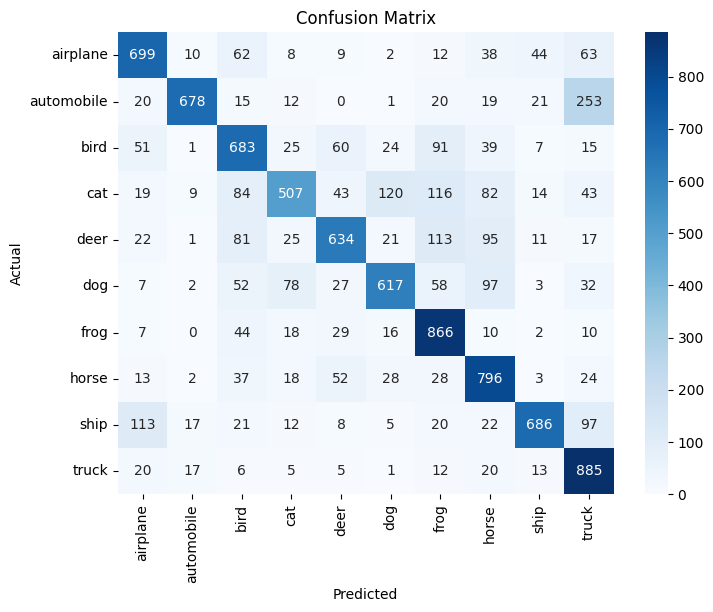

In [32]:
evaluate(model, test_dataloader, class_names)

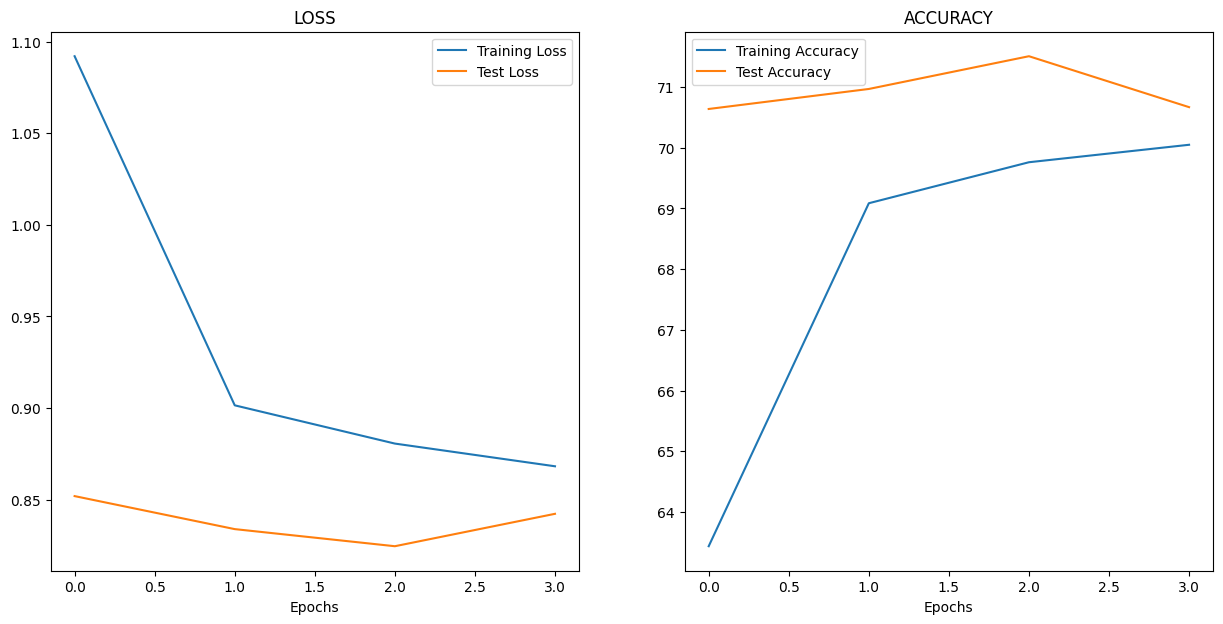

In [33]:
plot_curves(results)

**VISION TRANSFORMER**

In [ ]:
# get pretrained model weights
weights = torchvision.models.ViT_B_16_Weights.DEFAULT

model = torchvision.models.vit_b_16(weights=weights).to(device)
print(model)

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:03<00:00, 87.6MB/s]


VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

In [ ]:
# freeze the convolutional layers of the model
for param in model.encoder.parameters():
    param.requires_grad = False

In [ ]:
# update the classifier of the model
# the output size of the layer should be same as the number of classes in the data
model.heads = nn.Sequential(
    nn.Linear(768,len(cifar_data.classes))
).to(device)

print(model)

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

In [ ]:
# loss function
criterion = nn.CrossEntropyLoss()

# optimizer
optimizer = torch.optim.Adam(model.parameters(),lr=0.0004)

In [ ]:
epochs = 2

# results dictionary
results = {"train_loss": [],
            "test_loss": [],
}

In [ ]:
for epoch in tqdm(range(epochs)):
    train_loss,train_acc = train(model,train_dataloader,criterion,optimizer)
    test_loss,test_acc = test(model,test_dataloader,criterion)

    print(f"Epoch: {epoch+1} | train_loss: {train_loss:.4f} | train_acc: {train_acc:.2f}% | test_loss: {test_loss:.4f} | test_acc: {test_acc:.2f}%")
    #print(f"Epoch: {epoch+1} | train_loss: {train_loss:.4f} | train_acc: {train_acc:.2f}%")

    # update the results dictionary
    results["train_loss"].append(train_loss)
    #results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    #results["test_acc"].append(test_acc)

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.5163 | train_acc: 45.77% | test_loss: 0.9286 | test_acc: 68.84%
Epoch: 2 | train_loss: 0.9240 | train_acc: 68.09% | test_loss: 0.7990 | test_acc: 72.69%


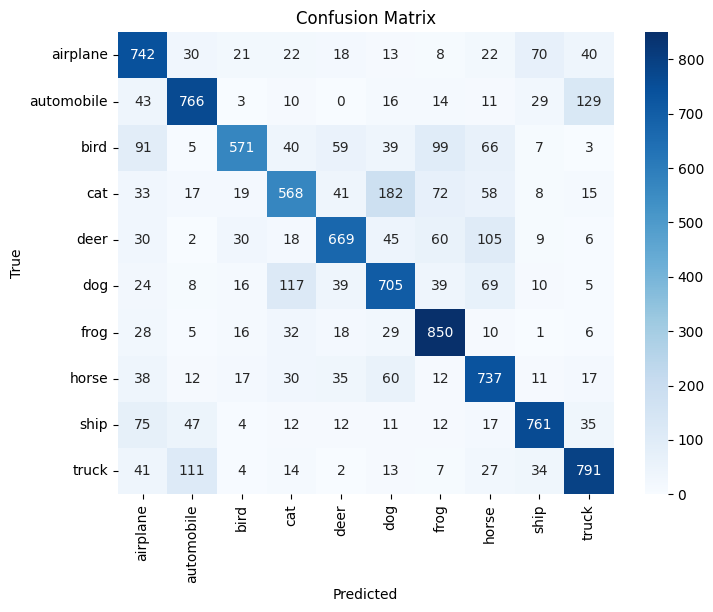

In [ ]:
evaluate(model, test_dataloader, class_names)

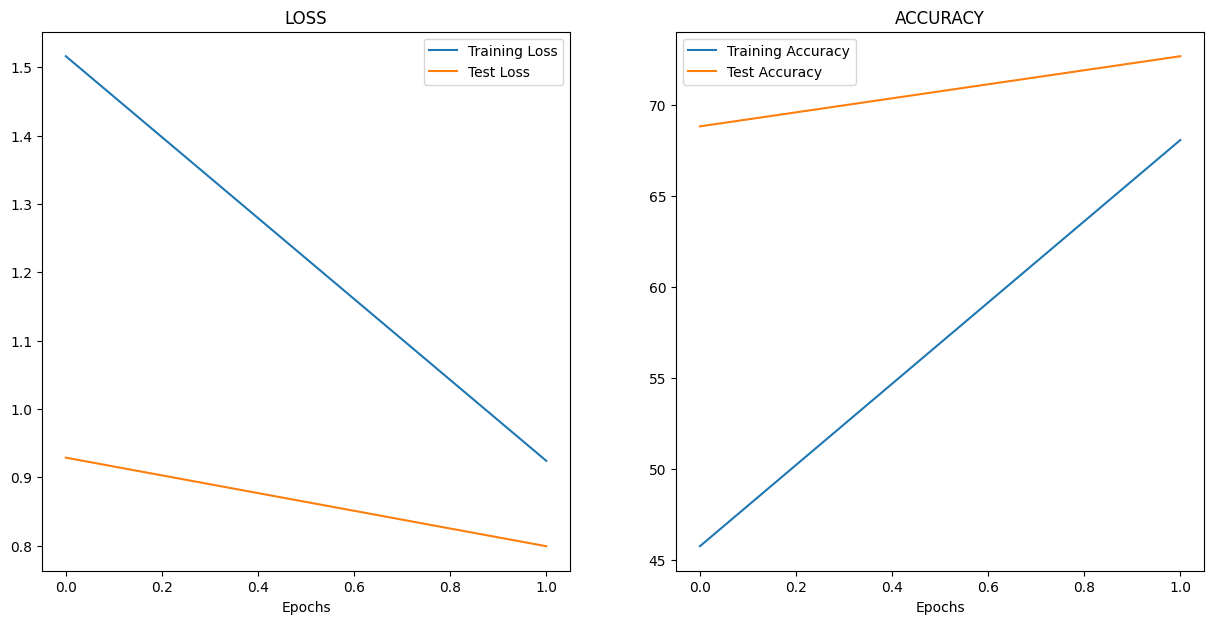

In [ ]:
plot_curves(results)